In [84]:
import warnings
import pandas as pd
from app import create_app
from app.models import db, User, Post, Comment, Upvote, Downvote
from sqlalchemy_schemadisplay import create_schema_graph
import plotly.express as px
import graphviz

warnings.filterwarnings('ignore') # filtering out annoying warning messages

# Getting app context from Flask
app = create_app()
app.app_context().push()

In [85]:
# Getting a printout of the Database Schema:
for table in db.metadata.tables.values():
    print("TABLE:", table.name)
    for column in table.c:
        print("COLUMN:", column.name, column.type, "NULLABLE:", column.nullable, "PRIMARY KEY:", column.primary_key,
              "DEFAULT:", column.default)

TABLE: user
COLUMN: id INTEGER NULLABLE: False PRIMARY KEY: True DEFAULT: None
COLUMN: username VARCHAR(20) NULLABLE: False PRIMARY KEY: False DEFAULT: None
COLUMN: email VARCHAR(120) NULLABLE: False PRIMARY KEY: False DEFAULT: None
COLUMN: password VARCHAR(60) NULLABLE: False PRIMARY KEY: False DEFAULT: None
COLUMN: date_created DATETIME NULLABLE: False PRIMARY KEY: False DEFAULT: ColumnDefault(<function datetime.utcnow at 0x119d90940>)
TABLE: post
COLUMN: id INTEGER NULLABLE: False PRIMARY KEY: True DEFAULT: None
COLUMN: topic VARCHAR(100) NULLABLE: True PRIMARY KEY: False DEFAULT: ColumnDefault('None')
COLUMN: title VARCHAR(100) NULLABLE: False PRIMARY KEY: False DEFAULT: None
COLUMN: date_posted DATETIME NULLABLE: False PRIMARY KEY: False DEFAULT: ColumnDefault(<function datetime.utcnow at 0x119d90f70>)
COLUMN: content TEXT NULLABLE: False PRIMARY KEY: False DEFAULT: None
COLUMN: user_id INTEGER NULLABLE: False PRIMARY KEY: False DEFAULT: None
COLUMN: view_count INTEGER NULLABLE: F

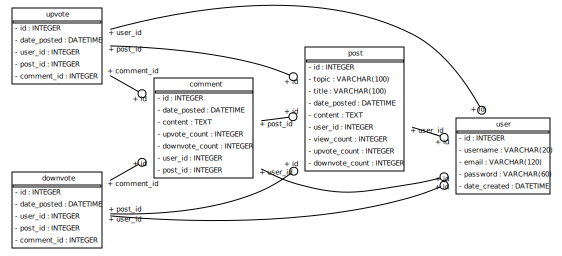

In [86]:
# Plotting a graph of the database schema:
graph = create_schema_graph(metadata=db.metadata, show_datatypes=True, show_indexes=True, rankdir='LR', concentrate=False)
dot_source = graph.to_string()
plot = graphviz.Source(dot_source)
plot

In [87]:
# Looking at users Table:
users = User.query
users_df = pd.read_sql(users.statement, users.session.bind)
users_df.head()

,id,username,email,password,date_created
0,1,Laura Milton,Laura.Milton@gmail.com,$2b$12$J8VHuKS/D/F7.e/DM77VeOy/oCwTBr8yEorPcXB...,2022-03-09 11:32:43
1,2,Nicole Toone,Nicole.Toone@gmail.com,$2b$12$4Vj1IHzPgDgdVE/.Cv2ree9qSA1xmyqyxCcBFjq...,2022-03-13 14:23:51
2,3,Sean Jourdan,Sean.Jourdan@gmail.com,$2b$12$7pbtIqsUnJw2qqoRDvX3eujWprwk631oaniMPGj...,2022-03-05 16:10:18
3,4,Ruth Broome,Ruth.Broome@gmail.com,$2b$12$2zyaoejNBqTVUi5k31RlLOGOKbrTrd3Uts89o0y...,2022-03-14 10:20:11
4,5,Dana Mitchell,Dana.Mitchell@gmail.com,$2b$12$Sl42BzKYIT.1xV3v1QytHO6m8yWqhqUCBSdS1EB...,2022-03-05 07:37:08


array([[<AxesSubplot:title={'center':'date_created'}>]], dtype=object)

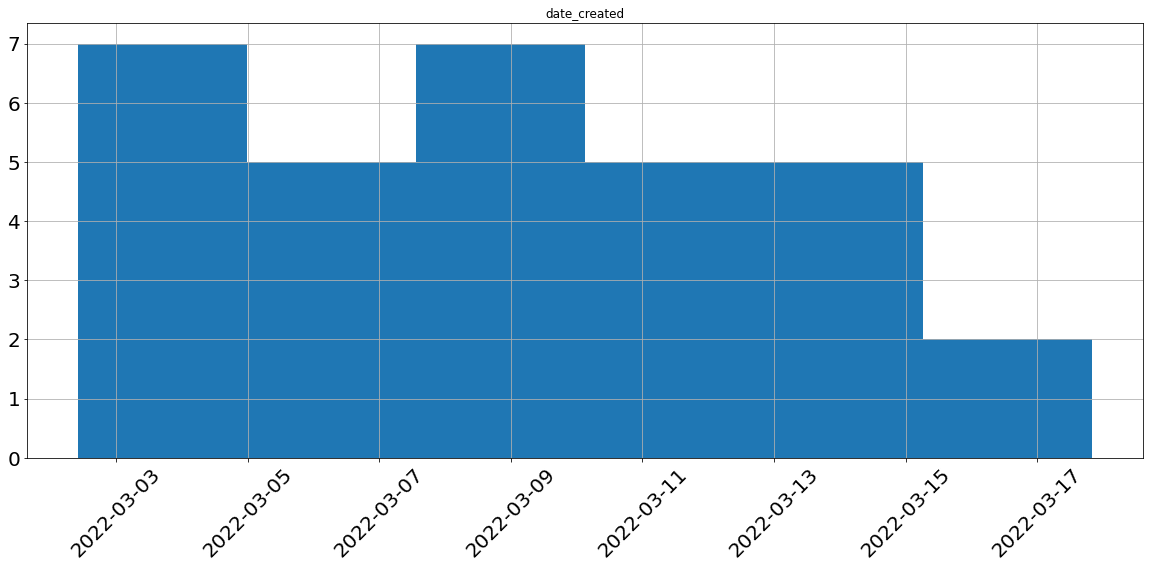

In [88]:
# Quick Histogram on users table:
users_df.hist(column='date_created', bins=6, figsize=(20,8), xlabelsize=20, xrot=45, ylabelsize=20)

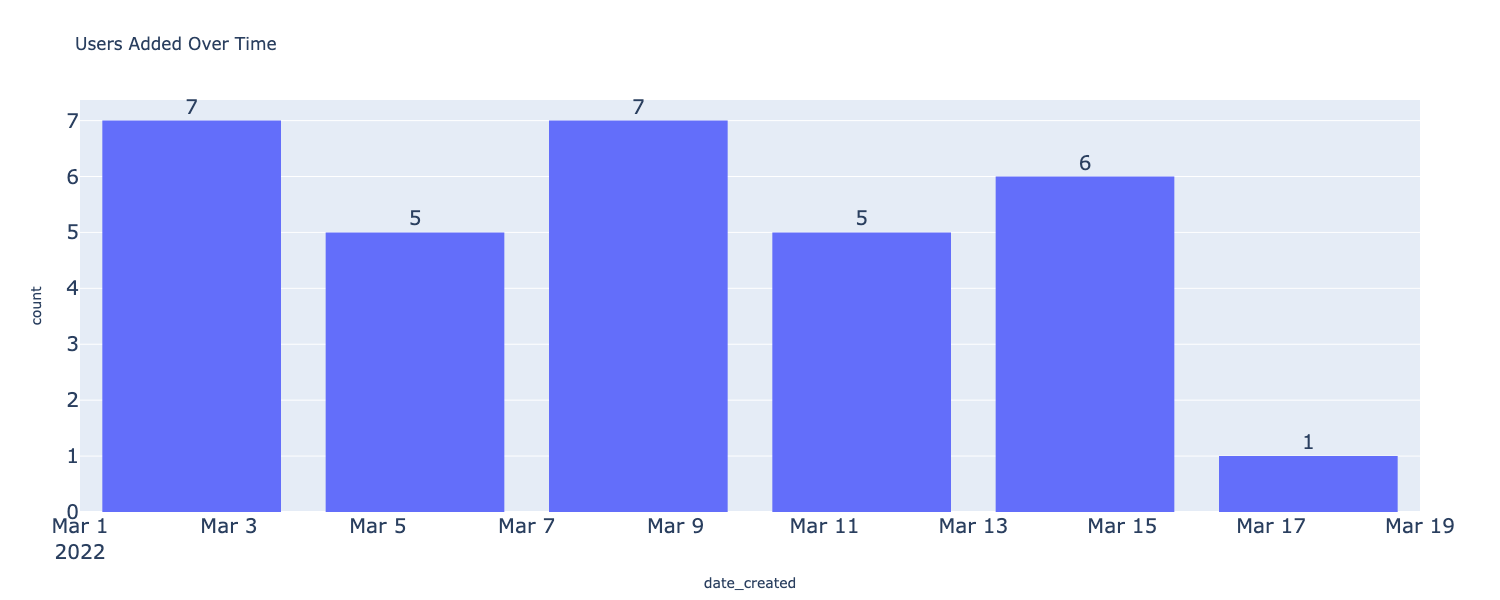

In [102]:
fig = px.histogram(
                users_df,
                title="Users Added Over Time",
                x="date_created",
                text_auto=True,
                height=600,
                width=1500,
            )
fig.update_layout(bargap=0.2)
fig.update_traces(textfont_size=20, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(bargap=0.2, yaxis = dict( tickfont = dict(size=20)), xaxis = dict( tickfont = dict(size=20)),
                  legend = dict(font = dict(size = 20)), legend_title = dict(font = dict(size = 20)))
fig.show('png')

In [89]:
# Getting histogram manually with pd.cut and groupby:
# pd.cut takes a series and number of bins to assign each element to one of those bins
users_df['datebin'] = pd.cut(users_df['date_created'], 6)
result = users_df.groupby('datebin').count()
result

,id,username,email,password,date_created
datebin,,,,,
"(2022-03-02 09:35:02.225893376, 2022-03-04 23:39:24.017788416]",7,7,7,7,7
"(2022-03-04 23:39:24.017788416, 2022-03-07 13:21:33.035576576]",5,5,5,5,5
"(2022-03-07 13:21:33.035576576, 2022-03-10 03:03:42.053364992]",7,7,7,7,7
"(2022-03-10 03:03:42.053364992, 2022-03-12 16:45:51.071153408]",5,5,5,5,5
"(2022-03-12 16:45:51.071153408, 2022-03-15 06:28:00.088941568]",5,5,5,5,5
"(2022-03-15 06:28:00.088941568, 2022-03-17 20:10:09.106729984]",2,2,2,2,2


Looking at User Posts Table:

In [90]:
# Getting top 10 posts by view count:
posts = db.session.query(Post, User).join(User)
posts_df = pd.read_sql(posts.statement, posts.session.bind)
posts_df.sort_values(by=['view_count'], ascending=True, inplace=True)
posts_df.tail(5)

,id,topic,title,date_posted,content,user_id,view_count,upvote_count,downvote_count,id_1,username,email,password,date_created
11,12,describe,How would your friends describe you?,2022-03-14 17:42:33,And all the books you've read have been read b...,14,454,11,13,14,Deborah Jones,Deborah.Jones@gmail.com,$2b$12$9JqrDSCrlYnq/XrW8VoMMuVCC56/6kKCfTTDTaO...,2022-03-09 22:22:47
14,15,what,At what age would you consider someone to be old?,2022-03-05 15:22:36,"Be who you are and say what you feel, because ...",5,473,23,8,5,Dana Mitchell,Dana.Mitchell@gmail.com,$2b$12$Sl42BzKYIT.1xV3v1QytHO6m8yWqhqUCBSdS1EB...,2022-03-05 07:37:08
24,26,you,How would you define success?,2022-03-15 01:37:03,"I'm selfish, impatient and a little insecure. ...",4,474,25,6,4,Ruth Broome,Ruth.Broome@gmail.com,$2b$12$2zyaoejNBqTVUi5k31RlLOGOKbrTrd3Uts89o0y...,2022-03-14 10:20:11
12,13,you,What website do you visit the most?,2022-03-11 18:30:36,"I'm selfish, impatient and a little insecure. ...",28,489,18,12,28,Robert Beckwith,Robert.Beckwith@gmail.com,$2b$12$rHg92B9OnC3tsNCfmAxSxOPmKs4i0q5YFr0P.co...,2022-03-10 06:54:24
17,18,What,What is your favorite food?,2022-03-15 06:37:01,"Be who you are and say what you feel, because ...",28,496,7,9,28,Robert Beckwith,Robert.Beckwith@gmail.com,$2b$12$rHg92B9OnC3tsNCfmAxSxOPmKs4i0q5YFr0P.co...,2022-03-10 06:54:24


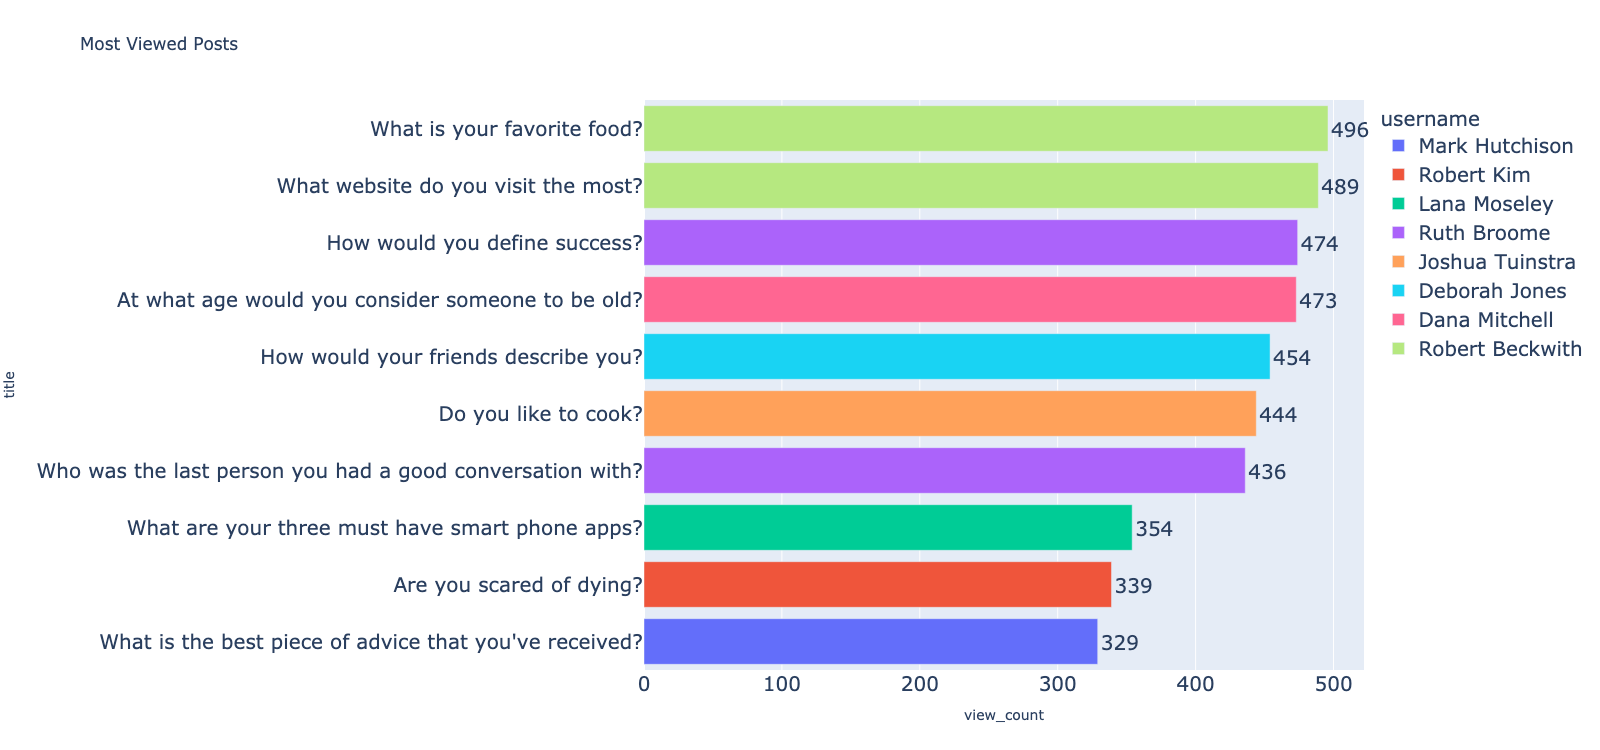

In [91]:
fig = px.bar(posts_df.tail(10), title="Most Viewed Posts", orientation='h', y="title", x='view_count', text_auto=True,
             height=750, width=1600, color="username")
fig.update_traces(textfont_size=20, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(bargap=0.2, yaxis = dict( tickfont = dict(size=20)), xaxis = dict( tickfont = dict(size=20)),
                  legend = dict(font = dict(size = 20)), legend_title = dict(font = dict(size = 20)))
fig.update_yaxes(categoryorder='total ascending')
fig.show('png') # 'png' is set for viewable output on Github.  Otherwise use fig.show() for interactive plot.

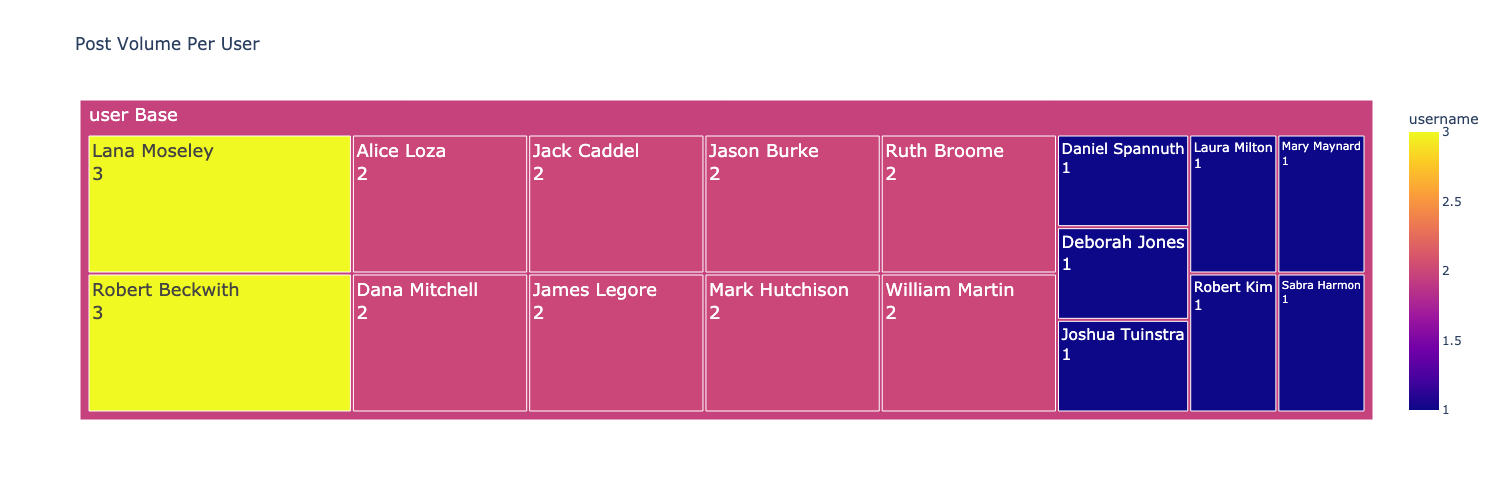

In [94]:
# Getting a treemap of Most Active Users According to Post Volume
posts_per_user = posts_df['username'].value_counts()
fig = px.treemap(posts_per_user, title='Post Volume Per User', path=[px.Constant("user Base"), posts_per_user.index],
                 values='username', color='username', width=1500)
fig.data[0].textinfo = 'label+text+value'
fig.update_traces(textfont_size=18)
fig.show('png') # 'png' is set for viewable output on Github.  Otherwise use fig.show() for interactive plot.